## Mecanismo de Atenção: motivação

No último notebook, vimos que cada token é representado por um vetor chamado de embeddings.

Estes embeddings são estáticos, ou seja, seu valor independe do contexto no qual o token está inserido.

Idealmente, seria interessante alterar o valor do embedding de uma palavra com base nas palavras adjascentes.

### Exemplo:
"Joana não atravessou a estrada porque ela estava cansada"

<div style="text-align: center;">
    <img src="figures/attention.png" alt="Atenção" width="50%"/>
</div>

####
| Token      | Col 1 | Col 2 | Col 3 | Col 4 | Col 5 | Col 6 | Col 7 |
|:-----------|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
| Joana      | 1     | 0     | 0     | 0     | 0     | 0     | 0     |
| não        | 0     | 1     | 0     | 0     | 0     | 0     | 0     |
| atravessou | 0     | 0     | 1     | 0     | 0     | 0     | 0     |
| a          | 0     | 0     | 0     | 1     | 0     | 0     | 0     |
| estrada    | 0     | 0     | 0     | 0     | 1     | 0     | 0     |
| porque     | 0     | 0     | 0     | 0     | 0     | 1     | 0     |
| ela        | 0     | 0     | 0     | 0     | 0     | 0     | 1     |

#### O ideal seria ter uma representação numérica que capturasse o sentido da palavra "ela" no contexto da frase anterior. 

####
| Token      | Col 1 | Col 2 | Col 3 | Col 4 | Col 5 | Col 6 | Col 7 |
|:-----------|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
| Joana      | 1     | 0     | 0     | 0     | 0     | 0     | 0     |
| não        | 0     | 1     | 0     | 0     | 0     | 0     | 0     |
| atravessou | 0     | 0     | 1     | 0     | 0     | 0     | 0     |
| a          | 0     | 0     | 0     | 1     | 0     | 0     | 0     |
| estrada    | 0     | 0     | 0     | 0     | 1     | 0     | 0     |
| porque     | 0.3     | 0     | 0     | 0.3     | 0     | 0.4     | 0     |
| ela        | 0     | 0     | 0     | 0     | 0     | 0     | 1     |

In [16]:
import torch
import torch.nn.functional as F
from torch import nn

In [17]:
X = torch.tensor([[1., 0., 0., 0., 0., 0., 0.],    # "Joana"
                  [0., 1., 0., 0., 0., 0., 0.],    # "não"
                  [0., 0., 1., 0., 0., 0., 0.],    # "atravessou"
                  [0., 0., 0., 1., 0., 0., 0.],    # "a"
                  [0., 0., 0., 0., 1., 0., 0.],    # "estrada"
                  [0., 0., 0., 0., 0., 1., 0.],    # "porque"
                  [0., 0., 0., 0., 0., 0., 1.]],    # "ela"
).float()

print(f'"Joana não atravessou a estrada porque ela"\n')
print(X.numpy())

"Joana não atravessou a estrada porque ela"

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


In [18]:
attention = torch.tensor([
                [1., 0., 0., 0., 0., 0., 0.], 
                [0., 1., 0., 0., 0., 0., 0.],
                [0., 0., 1., 0., 0., 0., 0.],
                [0., 0., 0., 1., 0., 0., 0.],
                [0., 0., 0., 0., 1., 0., 0.], 
                [0., 0., 0., 0., 0., 1., 0.],
                [0.3, 0., 0., 0., 0.3, 0., 0.4],    # mapa de atenção para a palavra "ela"
]).float()


print(f'Depois da atenção: \n')
print((attention.matmul(X)).numpy())

Depois da atenção: 

[[1.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0. ]
 [0.3 0.  0.  0.  0.3 0.  0.4]]


## Scaled Dot-Product Attention

$$
\text{Atenção}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

### Q (Queries), K (Keys) e V (Values)

In [19]:
X = torch.tensor([
    [1, 0, 0],      # "Olá"
    [0, 1, 0],      # "Mundo"
    [0, 0, 1]       # "!"
]).float()

EMBEDDING_DIM = 3

linear_q = torch.randn(EMBEDDING_DIM, EMBEDDING_DIM)
linear_v = torch.randn(EMBEDDING_DIM, EMBEDDING_DIM)
linear_k = torch.randn(EMBEDDING_DIM, EMBEDDING_DIM)

Q = torch.matmul(X, linear_q) # query
K = torch.matmul(X, linear_k) # key
V = torch.matmul(X, linear_v) # value

X.shape, Q.shape, K.shape, V.shape


(torch.Size([3, 3]),
 torch.Size([3, 3]),
 torch.Size([3, 3]),
 torch.Size([3, 3]))

#### O produto escalar é uma medida de similaridade entre a query e keys:

$$
\vec{q_i} \cdot \vec{k_i} = \|\vec{q_i}\| \|\vec{k_i}\| \cos(\theta)
$$

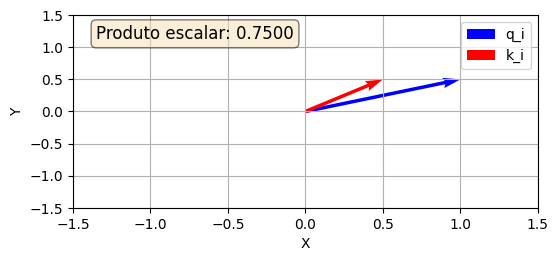

In [20]:
from utils import plot_tensors_2d

q_i = torch.tensor([1, 0.5]).float()
k_i = torch.tensor([0.5, 0.5]).float()
plot_tensors_2d(q_i, k_i, q_i @ k_i)

## Função Softmax

$$S(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$

Onde:
* $S(\mathbf{z})_i$ é a probabilidade resultante para o i-ésimo elemento do vetor de entrada.
* $z_i$ é o i-ésimo score (ou logit) no vetor de entrada $\mathbf{z}$.
* $e^{z_i}$ é o exponencial do i-ésimo score.
* $\sum_{j=1}^{K} e^{z_j}$ é a soma dos exponenciais de todos os $K$ scores no vetor. Isso atua como o termo de normalização.

In [21]:
scores = torch.tensor([1.0, 2.0, 1.0])
probabilidades = F.softmax(scores, dim=0)
print(f"Scores antes do Softmax: {scores.numpy()}")
print(f"Probabilidades de Atenção (após Softmax): {[f'{p:.5f}' for p in probabilidades]}\n")

Scores antes do Softmax: [1. 2. 1.]
Probabilidades de Atenção (após Softmax): ['0.21194', '0.57612', '0.21194']



In [22]:
# Scores com valores grandes
scores = torch.tensor([5.0, 10.0, 5.0])
probabilidades = F.softmax(scores, dim=0)
print(f"Scores antes do Softmax: {scores.numpy()}")
print(f"Probabilidades de Atenção (após Softmax): {[f'{p:.5f}' for p in probabilidades]}\n")

Scores antes do Softmax: [ 5. 10.  5.]
Probabilidades de Atenção (após Softmax): ['0.00665', '0.98670', '0.00665']



Dividimos o vetor de simularidade $QK^T$ por $\sqrt{d_k}$ para evitar saturação da função softmax.


In [23]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_model, head_dim, dropout):
        super().__init__()
        self.head_dim = head_dim
        self.fc_q = nn.Linear(d_model, head_dim)
        self.fc_k = nn.Linear(d_model, head_dim)
        self.fc_v = nn.Linear(d_model, head_dim)
        self.scale = torch.sqrt(torch.FloatTensor([head_dim]))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        Q, K, V = self.fc_q(x), self.fc_k(x), self.fc_v(x)
        qK = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        attention = torch.softmax(qK, dim=-1)
        return attention, torch.matmul(self.dropout(attention), V)

In [24]:
BATCH_SIZE = 1
SEQUENCE_LENGTH = 3
EMBEDDING_DIM = 3

att_layer = ScaledDotProductAttention(d_model=EMBEDDING_DIM, head_dim=EMBEDDING_DIM, dropout=0.1)

X = torch.randn(BATCH_SIZE, SEQUENCE_LENGTH, EMBEDDING_DIM)
attention_map, scaled_values = att_layer(X)

print(f'Mapa de Atenção:\n{attention_map.detach().numpy()}\n')

Mapa de Atenção:
[[[0.8396186  0.06666686 0.09371448]
  [0.45639935 0.25154802 0.2920527 ]
  [0.2793929  0.3604784  0.36012864]]]



## Masked Attention

In [25]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_model, head_dim, dropout):
        super().__init__()
        self.head_dim = head_dim
        self.fc_q = nn.Linear(d_model, head_dim)
        self.fc_k = nn.Linear(d_model, head_dim)
        self.fc_v = nn.Linear(d_model, head_dim)
        self.scale = torch.sqrt(torch.FloatTensor([head_dim]))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        Q, K, V = self.fc_q(x), self.fc_k(x), self.fc_v(x)
        qK = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        if mask is not None:
            # Substituimos valores iguais a zero na máscara por um número negativo muito grande
            qK = qK.masked_fill(mask == 0, -1e10)
        # Desta forma, a função softmax se encarrega zerar a atenção nos tokens futuros
        attention = torch.softmax(qK, dim=-1)
        return attention, torch.matmul(self.dropout(attention), V)

# Evitando valores futuros

In [26]:
mask = torch.tril(torch.ones(EMBEDDING_DIM, EMBEDDING_DIM))
mask

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [27]:
BATCH_SIZE = 1
SEQUENCE_LENGTH = 3
EMBEDDING_DIM = 3

att_layer = ScaledDotProductAttention(d_model=EMBEDDING_DIM, head_dim=EMBEDDING_DIM, dropout=0.1)

X = torch.randn(BATCH_SIZE, SEQUENCE_LENGTH, EMBEDDING_DIM)
attention_map, scaled_values = att_layer(X, mask=mask)

print(f'Mapa de Atenção:\n{attention_map.detach().numpy()}\n')

Mapa de Atenção:
[[[1.         0.         0.        ]
  [0.59190446 0.40809554 0.        ]
  [0.3406968  0.37001947 0.28928375]]]



## Multi-Head

<div style="text-align: center;">
    <img src="figures/mha.png" alt="Multi-Head Attention" width="50%"/>
</div>

In [28]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()

        assert d_model % n_heads == 0

        self.heads = nn.ModuleList([
            ScaledDotProductAttention(d_model, d_model // n_heads, dropout)
            for _ in range(n_heads)
        ])

        self.fc_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        head_outputs = [head(x, mask) for head in self.heads]
        attention_maps = [out[0] for out in head_outputs]
        values = [out[1] for out in head_outputs]

        concatenated = torch.cat(values, dim=-1)
        return attention_maps, self.fc_out(concatenated)

In [29]:
mha = MultiHeadAttention(d_model=EMBEDDING_DIM, n_heads=3, dropout=0.1)
attention_maps, values = mha(X, mask=mask)
attention_maps

[tensor([[[1.0000, 0.0000, 0.0000],
          [0.6712, 0.3288, 0.0000],
          [0.3793, 0.3053, 0.3155]]], grad_fn=<SoftmaxBackward0>),
 tensor([[[1.0000, 0.0000, 0.0000],
          [0.5081, 0.4919, 0.0000],
          [0.3306, 0.3299, 0.3394]]], grad_fn=<SoftmaxBackward0>),
 tensor([[[1.0000, 0.0000, 0.0000],
          [0.4688, 0.5312, 0.0000],
          [0.3422, 0.3298, 0.3280]]], grad_fn=<SoftmaxBackward0>)]

In [30]:
values

tensor([[[ 0.6617,  0.4190, -0.0291],
         [ 1.0027,  0.6326,  0.0453],
         [ 0.6540,  0.1420, -0.2340]]], grad_fn=<ViewBackward0>)